<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-and-load" data-toc-modified-id="Import-and-load-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import and load</a></span><ul class="toc-item"><li><span><a href="#load-all-data" data-toc-modified-id="load-all-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>load all data</a></span></li></ul></li><li><span><a href="#Overall-bar-chart" data-toc-modified-id="Overall-bar-chart-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Overall bar chart</a></span><ul class="toc-item"><li><span><a href="#Enriched-AE-in-each-subpopulation" data-toc-modified-id="Enriched-AE-in-each-subpopulation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Enriched AE in each subpopulation</a></span></li><li><span><a href="#Organ-difference-between-subpopulations" data-toc-modified-id="Organ-difference-between-subpopulations-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Organ difference between subpopulations</a></span></li><li><span><a href="#MedDRA-SOC-names" data-toc-modified-id="MedDRA-SOC-names-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>MedDRA SOC names</a></span></li></ul></li><li><span><a href="#Differential-analysis" data-toc-modified-id="Differential-analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Differential analysis</a></span><ul class="toc-item"><li><span><a href="#Gender" data-toc-modified-id="Gender-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Gender</a></span><ul class="toc-item"><li><span><a href="#Men" data-toc-modified-id="Men-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Men</a></span></li><li><span><a href="#Women" data-toc-modified-id="Women-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Women</a></span></li><li><span><a href="#Common-of-men-and-women" data-toc-modified-id="Common-of-men-and-women-3.1.3"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>Common of men and women</a></span></li></ul></li><li><span><a href="#Age" data-toc-modified-id="Age-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Age</a></span><ul class="toc-item"><li><span><a href="#Young" data-toc-modified-id="Young-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Young</a></span></li><li><span><a href="#Adult" data-toc-modified-id="Adult-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Adult</a></span></li><li><span><a href="#Elderly" data-toc-modified-id="Elderly-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Elderly</a></span></li><li><span><a href="#common-AE" data-toc-modified-id="common-AE-3.2.4"><span class="toc-item-num">3.2.4&nbsp;&nbsp;</span>common AE</a></span><ul class="toc-item"><li><span><a href="#Common-in-age" data-toc-modified-id="Common-in-age-3.2.4.1"><span class="toc-item-num">3.2.4.1&nbsp;&nbsp;</span>Common in age</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Sig-Drugs-Pairs" data-toc-modified-id="Sig-Drugs-Pairs-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Sig Drugs Pairs</a></span></li></ul></div>

# Import and load

In [1]:
print('Hi, Good morning, and in case I don\'t see you, good afternoon, good evening, and good night! ')

Hi, Good morning, and in case I don't see you, good afternoon, good evening, and good night! 


In [2]:
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
import faiss
from scipy import stats
from statsmodels.stats.multitest import multipletests
import scipy.stats as stats
from tqdm import tqdm
import plotly.express as px
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# calculate 95% confidential interval
def weird_division(n, d):
    return n / d if d else 0

def CI(ROR, A, B, C, D):
    ror = np.log(ROR)
    sq = 1.96*np.sqrt(weird_division(1, A) + weird_division(1, B) + weird_division(1, C) +weird_division(1, D))
    CI_up = np.exp(ror + sq)
    CI_down = np.exp(ror - sq)
    return CI_up, CI_down

def format_tex(float_number):
    exponent = np.floor(np.log10(float_number))
    mantissa = float_number/10**exponent
    mantissa_format = str(mantissa)[0:3]
    if float_number!=0:
        return "$< {0}\times10^{{{1}}}$".format(mantissa_format, str(int(exponent)))
    else:
        return "$< 0 \times10^{0}$"

## load all data

In [4]:
# Save the data
condition_list = ['SE_uncondition_2019_sig_over', 'SE_uncondition_2019_sig_under', 'SE_male_2019_sig_over', 'SE_male_2019_sig_under',
                 'SE_female_2019_sig_over', 'SE_female_2019_sig_under', 
                 'SE_young_2019_sig_over', 'SE_young_2019_sig_under',
                  'SE_adult_2019_sig_over', 'SE_adult_2019_sig_under',
                 'SE_elderly_2019_sig_over','SE_elderly_2019_sig_under']
over_count = []
under_count = []

for condition in condition_list:
    
    locals()[condition] = pickle.load(open('../Data/pandemic/results/'+condition+'_step2.pk', 'rb'))
    if condition.split('_')[1]=='uncondition':
        locals()[condition+'_original_name'] = list(locals()[condition].name)
    
    # Remove NaN (which not included in MedDra PT dictionary)
    locals()[condition] = locals()[condition][locals()[condition].SOC.notna()]
    
    
    # only keep the SE that has  both sig drug-SE  and sig pandemic  pair.
    keep_SE = pickle.load(open('../Data/pandemic/sig_drugSE_' + condition[3:]+'.pk', 'rb'))
    ind = [i in keep_SE for i in locals()[condition].SE]
    locals()[condition] = locals()[condition][ind]  
    
    
    
    # Narrow down 27 SOC to 23 SOC. Remove Social circumstances ('SocCi'), Surgical and medical procedures ('Surg'), product issue ('Prod')
    # Also remove Investigations, because this is not organ. We may analysis this seperately. 
    remove_list = ['SocCi', 'Surg', 'Prod', 'Inv']
    ind = [i not in remove_list for i in locals()[condition].SOC_abbr]
    locals()[condition] = locals()[condition][ind]


    ## drop AEs that are used for sanity check, or have vague meaning
    drop_SE = [ '10040560', '10060938', '10012335', '10011762','10011906','10016256', '10040642', '10000059', '10016322',
              '10033371','10042209', '10079987', '10022116','10050953', '10046274','10013971', '10013969', '10036590',
               '10084268', '10051905', '10084271','10084451','10070255','10084380',]  # to meddra ID
    drop_index = [i not in drop_SE for i in locals()[condition].SE]
    locals()[condition] = locals()[condition][drop_index]   

    #     """Only keep report amount >100, for all enriched AES"""
    if condition.split('_')[-1]=='over':
        locals()[condition] = locals()[condition][locals()[condition]['2020_A']>100]
    if condition.split('_')[-1]=='under':
        locals()[condition] = locals()[condition][locals()[condition]['2019_A']>100]
    
    if condition.split('_')[1]=='uncondition':
        locals()[condition+'_name'] = list(locals()[condition].name)
    
   
    if 'over' in condition:
        over_count.append(len(locals()[condition]))
    else:
        under_count.append(len(locals()[condition])) 
    
    print(condition, 'loaded with count (after remove drug):', len(locals()[condition]))

SE_uncondition_2019_sig_over loaded with count (after remove drug): 54
SE_uncondition_2019_sig_under loaded with count (after remove drug): 10
SE_male_2019_sig_over loaded with count (after remove drug): 16
SE_male_2019_sig_under loaded with count (after remove drug): 3
SE_female_2019_sig_over loaded with count (after remove drug): 38
SE_female_2019_sig_under loaded with count (after remove drug): 6
SE_young_2019_sig_over loaded with count (after remove drug): 1
SE_young_2019_sig_under loaded with count (after remove drug): 1
SE_adult_2019_sig_over loaded with count (after remove drug): 35
SE_adult_2019_sig_under loaded with count (after remove drug): 2
SE_elderly_2019_sig_over loaded with count (after remove drug): 18
SE_elderly_2019_sig_under loaded with count (after remove drug): 1


In [16]:
SE_uncondition_2019_sig_over.sort_values('PIC', ascending=False)

,SE,name,2019_A,2019_B,2020_A,2020_B,2019_ROR,2019_Delta,p_value,sig,p_corrected,CI_upper,CI_lower,PIC,SOC,SOC_name,SOC_abbr
1737,10012239,delusion,143,220777,345,210807,2.526689,1.412587,1.666331e-22,True,1.667664e-18,3.070792,2.078994,1.945519,10037175,psychiatric disorders,Psych
2946,10021113,hypothermia,57,220863,133,211019,2.442183,1.333333,4.080807e-09,True,4.084072e-05,3.330895,1.790587,1.668336,10022117,"injury, poisoning and procedural complications",Inj&P
13781,10075192,internal haemorrhage,86,220834,203,210949,2.471076,1.360465,2.066021e-13,True,2.067674e-09,3.180068,1.920153,1.643541,10047065,vascular disorders,Vasc
4893,10038695,respiratory failure,871,220049,1130,210022,1.359299,0.297359,1.018889e-11,True,1.019705e-07,1.485195,1.244074,1.576133,10038738,"respiratory, thoracic and mediastinal disorders",Resp
2909,10020983,hypogammaglobulinaemia,27,220893,198,210954,7.678840,6.333333,4.038578e-35,True,4.041809e-31,11.480060,5.136261,1.543415,10021428,immune system disorders,Immun
985,10006093,bradycardia,455,220465,601,210551,1.383074,0.320879,1.800228e-07,True,1.801669e-03,1.562449,1.224292,1.422794,10007541,cardiac disorders,Card
6498,10049771,shock haemorrhagic,44,220876,105,211047,2.497503,1.386364,1.062425e-07,True,1.063275e-03,3.551358,1.756376,1.401994,10027433,metabolism and nutrition disorders,Metab
3913,10029379,neutrophilia,103,220817,250,210902,2.541292,1.427184,7.664314e-17,True,7.670445e-13,3.197072,2.020025,1.323427,10005329,blood and lymphatic system disorders,Blood
3893,10029282,neuroleptic malignant syndrome,44,220876,106,211046,2.521300,1.409091,7.324029e-08,True,7.329888e-04,3.583439,1.773982,1.303680,10022117,"injury, poisoning and procedural complications",Inj&P
1744,10012267,dementia,206,220714,331,210821,1.682197,0.606796,3.523597e-09,True,3.526416e-05,2.001989,1.413487,1.242993,10037175,psychiatric disorders,Psych


In [17]:
SE_uncondition_2019_sig_under.sort_values('PIC', ascending=False)

,SE,name,2019_A,2019_B,2020_A,2020_B,2019_ROR,2019_Delta,p_value,sig,p_corrected,CI_upper,CI_lower,PIC,SOC,SOC_name,SOC_abbr
12565,10070608,infective pulmonary exacerbation of cystic fib...,661,220259,329,210823,0.520008,-0.502269,2.607747e-23,True,2.609833e-19,0.593610,0.455532,1.283704,10021881,infections and infestations,Infec
3050,10022004,influenza like illness,835,220085,619,210533,0.774951,-0.258683,1.481227e-06,True,1.482412e-02,0.859996,0.698317,1.259171,10018065,general disorders and administration site cond...,Genrl
2565,10018687,granulocytopenia,148,220772,27,211125,0.190768,-0.817568,2.461551e-20,True,2.463520e-16,0.287514,0.126577,1.246863,10005329,blood and lymphatic system disorders,Blood
10922,10064848,chronic kidney disease,2113,218807,640,210512,0.314822,-0.697113,2.404883e-169,True,2.406807e-165,0.344000,0.288118,1.121854,10038359,renal and urinary disorders,Renal
9730,10061481,renal injury,556,220364,127,211025,0.238526,-0.771583,6.892114e-61,True,6.897628e-57,0.289263,0.196688,1.030659,10038359,renal and urinary disorders,Renal
6062,10048302,tubulointerstitial nephritis,278,220642,163,210989,0.613156,-0.413669,5.080170e-07,True,5.084234e-03,0.744021,0.505309,0.921538,10038359,renal and urinary disorders,Renal
14358,10077512,end stage renal disease,585,220335,213,210939,0.380321,-0.635897,1.674309e-37,True,1.675648e-33,0.444959,0.325073,0.669077,10038359,renal and urinary disorders,Renal
3833,10028813,nausea,9373,211547,8349,202803,0.929155,-0.109250,1.748453e-06,True,1.749852e-02,0.957565,0.901588,0.413579,10017947,gastrointestinal disorders,Gastr
10867,10064658,osteonecrosis of jaw,198,220722,107,211045,0.565183,-0.459596,1.310105e-06,True,1.311153e-02,0.715081,0.446708,0.326692,10047065,vascular disorders,Vasc
160,10001507,agranulocytosis,141,220779,51,211101,0.378284,-0.638298,4.305451e-10,True,4.308896e-06,0.521114,0.274602,0.146084,10005329,blood and lymphatic system disorders,Blood


In [18]:
print(list(SE_uncondition_2019_sig_over.name))

['anxiety', 'arthralgia', 'bladder cancer', 'bradycardia', 'cardiac arrest', 'chest discomfort', 'chest pain', 'confusional state', 'cough', 'delusion', 'dementia', 'dizziness postural', 'dyspnoea', 'dystonia', 'fluid overload', 'fluid retention', 'gait disturbance', 'gastrointestinal haemorrhage', 'haematuria', 'haemorrhagic stroke', 'hallucination', 'hypertension', 'hypogammaglobulinaemia', 'hypotension', 'hypothermia', 'hypoxia', 'insomnia', 'melanocytic naevus', 'memory impairment', 'neuroleptic malignant syndrome', 'neuropathy peripheral', 'neurotoxicity', 'neutrophilia', 'oedema peripheral', 'pain in extremity', 'pain in jaw', 'pneumonia', 'premature delivery', 'psoriatic arthropathy', 'pulmonary hypertension', 'pyrexia', 'rectal haemorrhage', 'respiratory arrest', 'respiratory failure', 'tremor', 'urinary tract infection', 'visual acuity reduced', 'vitreous floaters', 'hypoacusis', 'shock haemorrhagic', 'cognitive disorder', 'cardiac disorder', 'neoplasm progression', 'internal 

In [15]:
print(list(SE_uncondition_2019_sig_under.name))

['agranulocytosis', 'granulocytopenia', 'influenza like illness', 'nausea', 'tubulointerstitial nephritis', 'renal injury', 'osteonecrosis of jaw', 'chronic kidney disease', 'infective pulmonary exacerbation of cystic fibrosis', 'end stage renal disease']


In [16]:
print(list(SE_uncondition_2019_sig_under.SE))

['10001507', '10018687', '10022004', '10028813', '10048302', '10061481', '10064658', '10064848', '10070608', '10077512']


In [17]:
print(list(SE_uncondition_2019_sig_under.name))

['agranulocytosis', 'granulocytopenia', 'influenza like illness', 'nausea', 'tubulointerstitial nephritis', 'renal injury', 'osteonecrosis of jaw', 'chronic kidney disease', 'infective pulmonary exacerbation of cystic fibrosis', 'end stage renal disease']


In [18]:
set(list(SE_uncondition_2019_sig_under['SOC_name']))

{'blood and lymphatic system disorders',
 'gastrointestinal disorders',
 'general disorders and administration site conditions',
 'infections and infestations',
 'renal and urinary disorders',
 'vascular disorders'}

# Overall bar chart

In [19]:
# under_count.append(0) # add the 0 for elderly_under
# under_count = [-1*i for i in under_count]
over_count.extend(under_count)

overview_df = pd.DataFrame({"Population": ['Unconditional', 'Male', 'Female', 'Young', 'Adult', 'Elderly', 
                                      'Unconditional', 'Male', 'Female', 'Young', 'Adult', 'Elderly'], 
                            "# of Adverse Effects": over_count,
                            "Trend": ['Enriched', 'Enriched', 'Enriched', 'Enriched', 'Enriched', 'Enriched', 
                                    'Purified', 'Purified', 'Purified', 'Purified', 'Purified', 'Purified']})
# overview_df

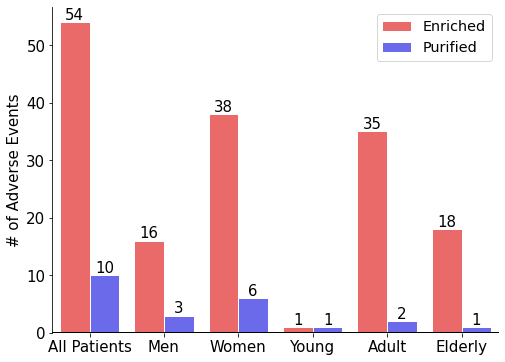

[54, 16, 38, 1, 35, 18, 10, 3, 6, 1, 2, 1]


In [20]:
import seaborn as sns
# sns.set()
import matplotlib.pyplot as plt
from mpl_toolkits.axisartist.axislines import SubplotZero
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() +0.5
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center", fontsize=15) 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()

overall_fig = sns.barplot(x = 'Population', y = '# of Adverse Effects', hue = 'Trend', data = overview_df,
            order = ['Unconditional', 'Male', 'Female', 'Young', 'Adult', 'Elderly'],
            palette = 'seismic_r', edgecolor = 'w')

ax.axes.xaxis.set_ticklabels(['All Patients', 'Men', 'Women', 'Young', 'Adult', 'Elderly'], fontsize=15)  # rename the xticks
ax.axes.set(xlabel=None)  # remove X label
ax.axes.axhline(y=0, color='black', linewidth=2)
ax.set_ylabel('# of Adverse Events', fontsize=15) 
sns.despine(top=True, right=True, left=False, bottom=True)
plt.yticks(fontsize=15)
plt.legend(fontsize='x-large')

show_values_on_bars(ax)

# plt.savefig('../Data/figures/bar_v7.pdf', bboxinchs='tight', transparent=True)
plt.show()
print(over_count)

## Enriched AE in each subpopulation

In [47]:
population = SE_uncondition_2019_sig_over
print('All population: there are {} adverse event, {} group adverse event'.format(len(population), len(set(list(population.SOC_abbr)))))

pd.options.display.max_rows = None
show_pd = population.drop(columns = ['p_value','sig','2019_B','2020_B'])
show_pd = show_pd[show_pd.SOC_abbr=='Psych']
show_pd.sort_values(by=['SOC_abbr','p_corrected'], ascending=[True, True])

All population: there are 54 adverse event, 19 group adverse event


,SE,name,2019_A,2020_A,2019_ROR,2019_Delta,p_corrected,CI_upper,CI_lower,PIC,SOC,SOC_name,SOC_abbr
2640,10019063,hallucination,699,1610,2.420674,1.303290,5.788152e-88,2.645943,2.214584,1.181543,10037175,psychiatric disorders,Psych
1737,10012239,delusion,143,345,2.526689,1.412587,1.667664e-18,3.070792,2.078994,1.945519,10037175,psychiatric disorders,Psych
355,10002855,anxiety,1777,2113,1.246558,0.189083,9.047010e-08,1.328109,1.170013,0.180231,10037175,psychiatric disorders,Psych
1744,10012267,dementia,206,331,1.682197,0.606796,3.526416e-05,2.001989,1.413487,1.242993,10037175,psychiatric disorders,Psych


In [48]:
population = SE_male_2019_sig_over
print('Men: there are {} adverse event, {} group adverse event'.format(len(population), len(set(list(population.SOC_abbr)))))

pd.options.display.max_rows = None
show_pd = population.drop(columns = ['p_value','sig','2019_B','2020_B'])
show_pd = show_pd[show_pd.SOC_abbr=='Psych']
show_pd.sort_values(by=['SOC_abbr','p_corrected'], ascending=[True, True])

Men: there are 16 adverse event, 7 group adverse event


,SE,name,2019_A,2020_A,2019_ROR,2019_Delta,p_corrected,CI_upper,CI_lower,PIC,SOC,SOC_name,SOC_abbr
2205,10019063,hallucination,318,870,2.792726,1.735849,4.906509e-58,3.176776,2.455105,1.231609,10037175,psychiatric disorders,Psych
1442,10012239,delusion,76,222,2.964882,1.921053,2.184045e-14,3.847882,2.284510,1.593735,10037175,psychiatric disorders,Psych
161,10001639,alcoholism,80,150,1.901142,0.875000,1.714550e-02,2.494276,1.449055,1.791609,10037175,psychiatric disorders,Psych
1448,10012267,dementia,88,159,1.832038,0.806818,2.838647e-02,2.377489,1.411726,1.241143,10037175,psychiatric disorders,Psych


In [49]:
population = SE_female_2019_sig_over
print('Women: there are {} adverse event, {} group adverse event'.format(len(population), len(set(list(population.SOC_abbr)))))

pd.options.display.max_rows = None
show_pd = population.drop(columns = ['p_value','sig','2019_B','2020_B'])
show_pd = show_pd[show_pd.SOC_abbr=='Psych']
show_pd.sort_values(by=['SOC_abbr','p_corrected'], ascending=[True, True])

Women: there are 38 adverse event, 14 group adverse event


,SE,name,2019_A,2020_A,2019_ROR,2019_Delta,p_corrected,CI_upper,CI_lower,PIC,SOC,SOC_name,SOC_abbr
2379,10019063,hallucination,303,612,2.097656,1.019802,1.662011e-23,2.407868,1.827410,1.255024,10037175,psychiatric disorders,Psych
309,10002855,anxiety,1095,1415,1.342529,0.292237,2.357739e-09,1.453343,1.240165,0.389801,10037175,psychiatric disorders,Psych


In [50]:
population = SE_young_2019_sig_over
print('Young: there are {} adverse event, {} group adverse event'.format(len(population), len(set(list(population.SOC_abbr)))))

pd.options.display.max_rows = None
show_pd = population.drop(columns = ['p_value','sig','2019_B','2020_B'])
# show_pd = show_pd[show_pd.SOC_abbr=='Inj&P']  #  Inj&P, Endo
show_pd.sort_values(by=['SOC_abbr','p_corrected'], ascending=[True, True])

Young: there are 1 adverse event, 1 group adverse event


,SE,name,2019_A,2020_A,2019_ROR,2019_Delta,p_corrected,CI_upper,CI_lower,PIC,SOC,SOC_name,SOC_abbr
2623,10037660,pyrexia,241,309,1.498803,0.282158,0.011605,1.779684,1.262253,1.077804,10018065,general disorders and administration site cond...,Genrl


In [51]:
population = SE_adult_2019_sig_over
print('Adult: there are {} adverse event, {} group adverse event'.format(len(population), len(set(list(population.SOC_abbr)))))

pd.options.display.max_rows = None 
show_pd = population.drop(columns = ['p_value','sig','2019_B','2020_B'])
show_pd = show_pd[show_pd.SOC_abbr=='Psych'] #Genrl, Musc, Skin
# specific in adults 'Card', 'Preg', 'Metab', 'Infec', 'Gastr', 'Musc'
show_pd.sort_values(by=['PIC','p_corrected'], ascending=[False, False])

Adult: there are 35 adverse event, 16 group adverse event


,SE,name,2019_A,2020_A,2019_ROR,2019_Delta,p_corrected,CI_upper,CI_lower,PIC,SOC,SOC_name,SOC_abbr
290,10002855,anxiety,709,856,1.356825,0.207334,0.000018,1.499652,1.227601,0.56345,10037175,psychiatric disorders,Psych


In [52]:
population = SE_elderly_2019_sig_over
print('Elderly: there are {} adverse event, {} group adverse event'.format(len(population), len(set(list(population.SOC_abbr)))))

pd.options.display.max_rows = None
show_pd = population.drop(columns = ['p_value','sig','2019_B','2020_B'])
show_pd = show_pd[show_pd.SOC_abbr=='Psych']  # Psych, Vasc
show_pd.sort_values(by=['SOC_abbr','p_corrected'], ascending=[True, True])

Elderly: there are 18 adverse event, 11 group adverse event


,SE,name,2019_A,2020_A,2019_ROR,2019_Delta,p_corrected,CI_upper,CI_lower,PIC,SOC,SOC_name,SOC_abbr
1881,10019063,hallucination,268,692,2.580394,1.582090,1.110036e-39,2.972949,2.239673,1.011931,10037175,psychiatric disorders,Psych
1215,10012239,delusion,63,177,2.788845,1.809524,9.362381e-10,3.719027,2.091315,1.067033,10037175,psychiatric disorders,Psych
6802,10061422,abnormal behaviour,46,132,2.846727,1.869565,4.932070e-07,3.982866,2.034680,1.164193,10037175,psychiatric disorders,Psych
102,10001488,aggression,43,105,2.421171,1.441860,2.188427e-03,3.453358,1.697498,1.464140,10037175,psychiatric disorders,Psych
1221,10012267,dementia,81,161,1.971567,0.987654,2.411218e-03,2.575747,1.509107,0.941578,10037175,psychiatric disorders,Psych


## Organ difference between subpopulations

In [33]:
"""The organs only appear in men or women"""
orgn_male = set(list(SE_male_2019_sig_over.SOC_abbr))
orgn_female = set(list(SE_female_2019_sig_over.SOC_abbr))
print('only male', orgn_male - orgn_female)
print('only female', orgn_female - orgn_male)
print('both male and female', orgn_male & orgn_female)

only male {'Immun', 'Blood'}
only female {'Infec', 'Ear', 'Skin', 'Neopl', 'Metab', 'Musc', 'Preg', 'Genrl', 'Renal'}
both male and female {'Vasc', 'Psych', 'Card', 'Nerv', 'Resp'}


In [34]:
"""The organs only appear in different gender"""
orgn_young = set(list(SE_young_2019_sig_over.SOC_abbr))
orgn_adult = set(list(SE_adult_2019_sig_over.SOC_abbr))
orgn_elderly = set(list(SE_elderly_2019_sig_over.SOC_abbr))

print('only young', orgn_young - orgn_adult-orgn_elderly)
print('only adult', orgn_adult -orgn_young -  orgn_elderly)
print('only elderly', orgn_elderly - orgn_adult-orgn_young)
print('adult+elderly',orgn_adult&orgn_elderly )

only young set()
only adult {'Blood', 'Skin', 'Immun', 'Metab', 'Musc', 'Preg', 'Resp'}
only elderly {'Eye', 'Ear'}
adult+elderly {'Vasc', 'Psych', 'Infec', 'Card', 'Neopl', 'Genrl', 'Repro', 'Renal', 'Nerv'}


## MedDRA SOC names

In [36]:
MedDRA_dic_all = pickle.load(open('../Data/curated/drug_mapping.pk', 'rb'))

SOCname = MedDRA_dic_all[['SOC_name', 'SOC_abbr']]

In [37]:
SOCname.drop_duplicates().sort_values('SOC_abbr')

,SOC_name,SOC_abbr
0,blood and lymphatic system disorders,Blood
0,cardiac disorders,Card
0,"congenital, familial and genetic disorders",Cong
0,ear and labyrinth disorders,Ear
0,endocrine disorders,Endo
0,eye disorders,Eye
0,gastrointestinal disorders,Gastr
0,general disorders and administration site cond...,Genrl
0,hepatobiliary disorders,Hepat
0,immune system disorders,Immun


# Differential analysis

For a specific subpopulation, what's the specific adverse events for it comparing to other populations? 

## Gender

### Men

In [42]:
unique_SE = set(list(SE_male_2019_sig_over.SE)) - set(list(SE_female_2019_sig_over.SE))

ind = [i in unique_SE for i in SE_male_2019_sig_over.SE]
male_unique = SE_male_2019_sig_over[ind]
male_unique

,SE,name,2019_A,2019_B,2020_A,2020_B,2019_ROR,2019_Delta,p_value,sig,p_corrected,CI_upper,CI_lower,PIC,SOC,SOC_name,SOC_abbr
161,10001639,alcoholism,80,73595,150,72583,1.901142,0.875000,2.373080e-06,True,1.714550e-02,2.494276,1.449055,1.791609,10037175,psychiatric disorders,Psych
822,10006093,bradycardia,173,73502,272,72461,1.594842,0.572254,1.471425e-06,True,1.063105e-02,1.930257,1.317711,0.648471,10007541,cardiac disorders,Card
1442,10012239,delusion,76,73599,222,72511,2.964882,1.921053,3.022900e-18,True,2.184045e-14,3.847882,2.284510,1.593735,10037175,psychiatric disorders,Psych
1448,10012267,dementia,88,73587,159,72574,1.832038,0.806818,3.928924e-06,True,2.838647e-02,2.377489,1.411726,1.241143,10037175,psychiatric disorders,Psych
2443,10020983,hypogammaglobulinaemia,5,73670,110,72623,22.317172,21.000000,2.219081e-27,True,1.603286e-23,54.688511,9.107145,1.907426,10021428,immune system disorders,Immun
3313,10029379,neutrophilia,36,73639,149,72584,4.199047,3.138889,4.429107e-18,True,3.200030e-14,6.043593,2.917469,1.476018,10005329,blood and lymphatic system disorders,Blood
4038,10038063,rectal haemorrhage,92,73583,169,72564,1.862752,0.836957,1.134667e-06,True,8.197966e-03,2.401772,1.444703,0.612665,10047065,vascular disorders,Vasc
4129,10038695,respiratory failure,373,73302,516,72217,1.404162,0.383378,6.044849e-07,True,4.367403e-03,1.604872,1.228554,0.960850,10038738,"respiratory, thoracic and mediastinal disorders",Resp
6051,10052015,cytokine release syndrome,128,73547,228,72505,1.806849,0.781250,5.186000e-08,True,3.746885e-04,2.244096,1.454797,0.082337,10021428,immune system disorders,Immun
11268,10075192,internal haemorrhage,45,73630,107,72626,2.410649,1.377778,3.346073e-07,True,2.417538e-03,3.415376,1.701490,0.898323,10047065,vascular disorders,Vasc


In [34]:
unique_SE = set(list(SE_male_2019_sig_under.SE)) - set(list(SE_female_2019_sig_under.SE))

ind = [i in unique_SE for i in SE_male_2019_sig_under.SE]
unique = SE_male_2019_sig_under[ind]
unique

,SE,name,2019_A,2019_B,2020_A,2020_B,2019_ROR,2019_Delta,p_value,sig,p_corrected,CI_upper,CI_lower,PIC,SOC,SOC_name,SOC_abbr
2153,10018800,gynaecomastia,187,73488,101,72632,0.546472,-0.459893,6.240589e-07,True,0.004509,0.696266,0.428905,0.208140,10038604,reproductive system and breast disorders,Repro
2223,10019211,headache,1960,71715,1617,71116,0.831949,-0.175000,5.965123e-08,True,0.000431,0.889295,0.778300,0.760013,10029205,nervous system disorders,Nerv


### Women

In [19]:
population = SE_female_2019_sig_over
unique_SE = set(list(population.SE)) - set(list(SE_male_2019_sig_over.SE))

ind = [i in unique_SE for i in population.SE]
unique = population[ind]
print('unique AE:', len(unique))
unique.sort_values('PIC', ascending=False)

unique AE: 32


,SE,name,2019_A,2019_B,2020_A,2020_B,2019_ROR,2019_Delta,p_value,sig,p_corrected,CI_upper,CI_lower,PIC,SOC,SOC_name,SOC_abbr
4123,10036595,premature delivery,145,117820,257,113650,1.837446,0.772414,2.965380e-09,True,2.401068e-05,2.252661,1.498765,2.525061,10036585,"pregnancy, puerperium and perinatal conditions",Preg
1672,10013578,dizziness postural,48,117917,114,113793,2.461073,1.375000,5.814628e-08,True,4.708104e-04,3.448491,1.756385,1.439076,10029205,nervous system disorders,Nerv
2661,10021097,hypotension,1119,116846,1362,112545,1.263673,0.217158,7.505287e-09,True,6.077031e-05,1.368240,1.167098,1.369910,10047065,vascular disorders,Vasc
4225,10037400,pulmonary hypertension,231,117734,386,113521,1.733010,0.670996,2.214843e-11,True,1.793359e-07,2.040317,1.471988,1.342232,10047065,vascular disorders,Vasc
3756,10033425,pain in extremity,1787,116178,2088,111819,1.213988,0.168439,2.419136e-09,True,1.958774e-05,1.293828,1.139074,1.213873,10028395,musculoskeletal and connective tissue disorders,Musc
3227,10027145,melanocytic naevus,40,117925,119,113788,3.083162,1.975000,4.955707e-11,True,4.012636e-07,4.411741,2.154680,1.204013,10040785,skin and subcutaneous tissue disorders,Skin
3757,10033433,pain in jaw,419,117546,715,113192,1.772083,0.706444,3.808433e-21,True,3.083688e-17,1.999744,1.570340,1.096737,10028395,musculoskeletal and connective tissue disorders,Musc
2675,10021143,hypoxia,300,117665,438,113469,1.513990,0.460000,2.862423e-08,True,2.317704e-04,1.753936,1.306869,1.026912,10038738,"respiratory, thoracic and mediastinal disorders",Resp
5199,10046571,urinary tract infection,1257,116708,1665,112242,1.377286,0.324582,1.284992e-17,True,1.040458e-13,1.482615,1.279440,0.976895,10021881,infections and infestations,Infec
2086,10016803,fluid overload,216,117749,326,113581,1.564643,0.509259,2.802065e-07,True,2.268832e-03,1.858571,1.317199,0.923678,10027433,metabolism and nutrition disorders,Metab


In [20]:
Sankey_selected = list(unique[unique.PIC>0.8])

In [37]:
show = unique[unique.SOC_abbr=='Musc']
show.sort_values(by=['SOC_abbr','p_corrected'], ascending=[True, True])

,SE,name,2019_A,2019_B,2020_A,2020_B,2019_ROR,2019_Delta,p_value,sig,p_corrected,CI_upper,CI_lower,PIC,SOC,SOC_name,SOC_abbr
3757,10033433,pain in jaw,419,117546,715,113192,1.772083,0.706444,3.808433e-21,True,3.083688e-17,1.999744,1.570340,1.096737,10028395,musculoskeletal and connective tissue disorders,Musc
2148,10017577,gait disturbance,819,117146,1054,112853,1.335891,0.286935,5.458485e-10,True,4.419735e-06,1.464131,1.218883,0.836810,10028395,musculoskeletal and connective tissue disorders,Musc
3756,10033425,pain in extremity,1787,116178,2088,111819,1.213988,0.168439,2.419136e-09,True,1.958774e-05,1.293828,1.139074,1.213873,10028395,musculoskeletal and connective tissue disorders,Musc
383,10003239,arthralgia,2144,115821,2424,111483,1.174591,0.130597,7.952653e-08,True,6.439263e-04,1.245587,1.107640,0.018412,10028395,musculoskeletal and connective tissue disorders,Musc
474,10003988,back pain,1329,116636,1549,112358,1.209916,0.165538,4.015419e-07,True,3.251285e-03,1.302508,1.123905,0.394507,10028395,musculoskeletal and connective tissue disorders,Musc


In [39]:
unique_SE = set(list(SE_female_2019_sig_under.SE)) - set(list(SE_male_2019_sig_under.SE))

ind = [i in unique_SE for i in SE_female_2019_sig_under.SE]
unique = SE_female_2019_sig_under[ind]
unique

,SE,name,2019_A,2019_B,2020_A,2020_B,2019_ROR,2019_Delta,p_value,sig,p_corrected,CI_upper,CI_lower,PIC,SOC,SOC_name,SOC_abbr
1029,10007617,cardio-respiratory arrest,249,117716,99,113808,0.411243,-0.602410,4.684562e-15,True,3.793090e-11,0.519156,0.325761,0.013643,10038738,"respiratory, thoracic and mediastinal disorders",Resp
3476,10028813,nausea,6293,111672,5486,108421,0.897902,-0.128238,1.303619e-08,True,1.055540e-04,0.931892,0.865152,0.204774,10017947,gastrointestinal disorders,Gastr
3763,10033553,palmar-plantar erythrodysaesthesia syndrome,155,117810,79,113828,0.527507,-0.490323,2.173666e-06,True,1.760017e-02,0.691755,0.402258,0.472194,10029205,nervous system disorders,Nerv
8663,10061481,renal injury,185,117780,59,113848,0.329934,-0.681081,1.494678e-15,True,1.210241e-11,0.442328,0.246098,0.426409,10038359,renal and urinary disorders,Renal
9704,10064848,chronic kidney disease,494,117471,194,113713,0.405691,-0.607287,5.921405e-29,True,4.794562e-25,0.479076,0.343547,0.549602,10038359,renal and urinary disorders,Renal


### Common of men and women

In [40]:
population = SE_female_2019_sig_over
unique_SE = set(list(population.SE)) & set(list(SE_male_2019_sig_over.SE))

ind = [i in unique_SE for i in population.SE]
unique = population[ind]
print('unique AE:', len(unique))
unique.sort_values('p_corrected')

unique AE: 6


,SE,name,2019_A,2019_B,2020_A,2020_B,2019_ROR,2019_Delta,p_value,sig,p_corrected,CI_upper,CI_lower,PIC,SOC,SOC_name,SOC_abbr
4417,10038669,respiratory arrest,34,117931,308,113599,9.404274,8.058824,8.828447e-59,True,7.148394e-55,13.402787,6.598655,0.743239,10038738,"respiratory, thoracic and mediastinal disorders",Resp
3536,10029331,neuropathy peripheral,539,117426,955,112952,1.841980,0.771800,9.175146e-31,True,7.429116e-27,2.047767,1.656874,1.231428,10029205,nervous system disorders,Nerv
2379,10019063,hallucination,303,117662,612,113295,2.097656,1.019802,2.052626e-27,True,1.662011e-23,2.407868,1.827410,1.255024,10037175,psychiatric disorders,Psych
2221,10017955,gastrointestinal haemorrhage,338,117627,659,113248,2.025094,0.949704,3.358316e-27,True,2.719228e-23,2.309428,1.775767,0.567239,10047065,vascular disorders,Vasc
1006,10007515,cardiac arrest,321,117644,631,113276,2.041532,0.965732,1.132456e-26,True,9.169496e-23,2.335719,1.784399,0.881957,10007541,cardiac disorders,Card
1330,10010305,confusional state,640,117325,787,113120,1.275399,0.229687,5.453055e-06,True,4.415339e-02,1.416096,1.148681,0.941412,10029205,nervous system disorders,Nerv


In [41]:
population = SE_male_2019_sig_over
ind = [i in unique_SE for i in population.SE]
unique = population[ind]
print('unique AE:', len(unique))
unique.sort_values('p_corrected')

unique AE: 6


,SE,name,2019_A,2019_B,2020_A,2020_B,2019_ROR,2019_Delta,p_value,sig,p_corrected,CI_upper,CI_lower,PIC,SOC,SOC_name,SOC_abbr
2205,10019063,hallucination,318,73357,870,71863,2.792726,1.735849,6.791015e-62,True,4.906509e-58,3.176776,2.455105,1.231609,10037175,psychiatric disorders,Psych
4125,10038669,respiratory arrest,31,73644,250,72483,8.193690,7.064516,1.336399e-44,True,9.655485e-41,11.902156,5.640705,0.797884,10038738,"respiratory, thoracic and mediastinal disorders",Resp
3300,10029331,neuropathy peripheral,353,73322,803,71930,2.318810,1.274788,1.470464e-42,True,1.062410e-38,2.629103,2.045137,0.953288,10029205,nervous system disorders,Nerv
935,10007515,cardiac arrest,339,73336,631,72102,1.893213,0.861357,3.950220e-22,True,2.854034e-18,2.161195,1.658461,1.116258,10007541,cardiac disorders,Card
2049,10017955,gastrointestinal haemorrhage,403,73272,707,72026,1.784691,0.754342,5.372975e-21,True,3.881975e-17,2.017811,1.578504,0.593775,10047065,vascular disorders,Vasc
1230,10010305,confusional state,494,73181,750,71983,1.543486,0.518219,5.635075e-14,True,4.071342e-10,1.729930,1.377136,0.256930,10029205,nervous system disorders,Nerv


In [42]:
population = SE_female_2019_sig_under
unique_SE = set(list(population.SE)) & set(list(SE_male_2019_sig_under.SE))

ind = [i in unique_SE for i in population.SE]
unique = population[ind]
print('unique AE:', len(unique))
unique.sort_values('p_corrected')

unique AE: 1


,SE,name,2019_A,2019_B,2020_A,2020_B,2019_ROR,2019_Delta,p_value,sig,p_corrected,CI_upper,CI_lower,PIC,SOC,SOC_name,SOC_abbr
11115,10070608,infective pulmonary exacerbation of cystic fib...,378,117587,184,113723,0.503312,-0.513228,4.457624e-15,True,3.609338e-11,0.600392,0.421929,1.211416,10021881,infections and infestations,Infec


## Age

###  Young

Young don't have underrepresented.

In [53]:
si = 'over'
population = locals()['SE_young_2019_sig_' + si]
if si=='over':
    unique_SE = set(list(population.SE)) -  set(list(locals()['SE_adult_2019_sig_' + si].SE))- set(list(locals()['SE_elderly_2019_sig_' + si].SE))
else:
    unique_SE = set(list(population.SE)) -  set(list(locals()['SE_adult_2019_sig_' + si].SE))


ind = [i in unique_SE for i in population.SE]
unique = population[ind]
unique.sort_values('p_corrected')

,SE,name,2019_A,2019_B,2020_A,2020_B,2019_ROR,2019_Delta,p_value,sig,p_corrected,CI_upper,CI_lower,PIC,SOC,SOC_name,SOC_abbr


In [44]:
show = unique[unique.SOC_abbr=='Neopl']
show.sort_values(by=['SOC_abbr','p_corrected'], ascending=[True, True])

,SE,name,2019_A,2019_B,2020_A,2020_B,2019_ROR,2019_Delta,p_value,sig,p_corrected,CI_upper,CI_lower,PIC,SOC,SOC_name,SOC_abbr


### Adult

In [57]:
si = 'over'
population = locals()['SE_adult_2019_sig_' + si]
if si=='over':
    unique_SE = set(list(population.SE)) -  set(list(locals()['SE_young_2019_sig_' + si].SE))- set(list(locals()['SE_elderly_2019_sig_' + si].SE))
# else:
#     unique_SE = set(list(population.SE)) -  set(list(locals()['SE_young_2019_sig_' + si].SE))


ind = [i in unique_SE for i in population.SE]
unique = population[ind]
print(len(unique))
unique.sort_values('PIC', ascending=False)

28


,SE,name,2019_A,2019_B,2020_A,2020_B,2019_ROR,2019_Delta,p_value,sig,p_corrected,CI_upper,CI_lower,PIC,SOC,SOC_name,SOC_abbr
3535,10033433,pain in jaw,256,73953,440,65818,1.931185,0.718750,1.631806e-17,True,1.194972e-13,2.253670,1.654845,1.605565,10028395,musculoskeletal and connective tissue disorders,Musc
3892,10036595,premature delivery,115,74094,238,66020,2.322665,1.069565,2.330028e-14,True,1.706280e-10,2.902442,1.858702,1.578061,10036585,"pregnancy, puerperium and perinatal conditions",Preg
3998,10037400,pulmonary hypertension,112,74097,214,66044,2.143695,0.910714,2.333470e-11,True,1.708800e-07,2.694889,1.705238,1.481979,10047065,vascular disorders,Vasc
9179,10064911,pulmonary arterial hypertension,141,74068,229,66029,1.821849,0.624113,1.442764e-08,True,1.056536e-04,2.247740,1.476653,1.428243,10047065,vascular disorders,Vasc
3335,10029379,neutrophilia,41,74168,181,66077,4.955198,3.414634,5.286753e-26,True,3.871489e-22,6.955971,3.529914,1.336609,10005329,blood and lymphatic system disorders,Blood
3031,10027145,melanocytic naevus,37,74172,120,66138,3.637211,2.243243,1.169548e-13,True,8.564598e-10,5.258950,2.515578,1.319052,10040785,skin and subcutaneous tissue disorders,Skin
4184,10038695,respiratory failure,335,73874,444,65814,1.487687,0.325373,4.104402e-08,True,3.005653e-04,1.715072,1.290449,1.291311,10038738,"respiratory, thoracic and mediastinal disorders",Resp
2512,10021143,hypoxia,226,73983,318,65940,1.578708,0.407080,1.374174e-07,True,1.006308e-03,1.872837,1.330771,1.136687,10038738,"respiratory, thoracic and mediastinal disorders",Resp
3781,10035664,pneumonia,1095,73114,1192,65066,1.223231,0.088584,1.795231e-06,True,1.314648e-02,1.328721,1.126117,1.120378,10021881,infections and infestations,Infec
6857,10055798,haemorrhage,182,74027,313,65945,1.930551,0.719780,6.913658e-13,True,5.062872e-09,2.318248,1.607691,1.074605,10047065,vascular disorders,Vasc


In [48]:
show = unique[unique.SOC_abbr=='Musc']
show.sort_values(by=['SOC_abbr','p_corrected'], ascending=[True, True])

,SE,name,2019_A,2019_B,2020_A,2020_B,2019_ROR,2019_Delta,p_value,sig,p_corrected,CI_upper,CI_lower,PIC,SOC,SOC_name,SOC_abbr
3535,10033433,pain in jaw,256,73953,440,65818,1.931185,0.718750,1.631806e-17,True,1.194972e-13,2.253670,1.654845,1.605565,10028395,musculoskeletal and connective tissue disorders,Musc
3534,10033425,pain in extremity,1043,73166,1204,65054,1.298307,0.154362,9.291557e-10,True,6.804207e-06,1.411482,1.194207,0.854848,10028395,musculoskeletal and connective tissue disorders,Musc
361,10003239,arthralgia,1298,72911,1422,64836,1.231975,0.095532,7.607208e-08,True,5.570758e-04,1.329229,1.141836,0.722849,10028395,musculoskeletal and connective tissue disorders,Musc


### Elderly

In [58]:
si = 'over'
population = locals()['SE_elderly_2019_sig_' + si]
unique_SE = set(list(population.SE)) - set(list(locals()['SE_young_2019_sig_' + si].SE))-  set(list(locals()['SE_adult_2019_sig_' + si].SE))


ind = [i in unique_SE for i in population.SE]
unique = population[ind]
print(len(unique))

unique.sort_values('PIC', ascending=False)

12


,SE,name,2019_A,2019_B,2020_A,2020_B,2019_ROR,2019_Delta,p_value,sig,p_corrected,CI_upper,CI_lower,PIC,SOC,SOC_name,SOC_abbr
102,10001488,aggression,43,45874,105,46266,2.421171,1.441860,3.731970e-07,True,2.188427e-03,3.453358,1.697498,1.464140,10037175,psychiatric disorders,Psych
4320,10047654,vitreous floaters,18,45899,147,46224,8.109247,7.166667,2.632615e-26,True,1.543765e-22,13.231754,4.969854,1.397767,10015919,eye disorders,Eye
6802,10061422,abnormal behaviour,46,45871,132,46239,2.846727,1.869565,8.410761e-11,True,4.932070e-07,3.982866,2.034680,1.164193,10037175,psychiatric disorders,Psych
1215,10012239,delusion,63,45854,177,46194,2.788845,1.809524,1.596586e-13,True,9.362381e-10,3.719027,2.091315,1.067033,10037175,psychiatric disorders,Psych
1844,10018867,haematuria,95,45822,190,46181,1.984452,1.000000,2.617627e-08,True,1.534976e-04,2.539502,1.550718,1.036579,10038604,reproductive system and breast disorders,Repro
1881,10019063,hallucination,268,45649,692,45679,2.580394,1.582090,1.892968e-43,True,1.110036e-39,2.972949,2.239673,1.011931,10037175,psychiatric disorders,Psych
9356,10075192,internal haemorrhage,37,45880,109,46262,2.921620,1.945946,2.047677e-09,True,1.200758e-05,4.243058,2.011725,0.970513,10047065,vascular disorders,Vasc
1221,10012267,dementia,81,45836,161,46210,1.971567,0.987654,4.111900e-07,True,2.411218e-03,2.575747,1.509107,0.941578,10037175,psychiatric disorders,Psych
4627,10049438,general physical health deterioration,77,45840,153,46218,1.970762,0.987013,8.335960e-07,True,4.888207e-03,2.592402,1.498187,0.912517,10018065,general disorders and administration site cond...,Genrl
4178,10046571,urinary tract infection,621,45296,803,45568,1.285357,0.293076,2.900992e-06,True,1.701141e-02,1.428435,1.156610,0.894225,10021881,infections and infestations,Infec


In [61]:
show = unique[unique.SOC_abbr=='Psych']  # Psych, Neopl
show.sort_values(by=['SOC_abbr','p_corrected'], ascending=[True, True])

,SE,name,2019_A,2019_B,2020_A,2020_B,2019_ROR,2019_Delta,p_value,sig,p_corrected,CI_upper,CI_lower,PIC,SOC,SOC_name,SOC_abbr
1881,10019063,hallucination,268,45649,692,45679,2.580394,1.582090,1.892968e-43,True,1.110036e-39,2.972949,2.239673,1.011931,10037175,psychiatric disorders,Psych
1215,10012239,delusion,63,45854,177,46194,2.788845,1.809524,1.596586e-13,True,9.362381e-10,3.719027,2.091315,1.067033,10037175,psychiatric disorders,Psych
6802,10061422,abnormal behaviour,46,45871,132,46239,2.846727,1.869565,8.410761e-11,True,4.932070e-07,3.982866,2.034680,1.164193,10037175,psychiatric disorders,Psych
102,10001488,aggression,43,45874,105,46266,2.421171,1.441860,3.731970e-07,True,2.188427e-03,3.453358,1.697498,1.464140,10037175,psychiatric disorders,Psych
1221,10012267,dementia,81,45836,161,46210,1.971567,0.987654,4.111900e-07,True,2.411218e-03,2.575747,1.509107,0.941578,10037175,psychiatric disorders,Psych


### common AE

#### Common in age

In [75]:
## Young and Adult and Elderly

si = 'over'
if si == 'over':
    common_AE = set(list(locals()['SE_young_2019_sig_' + si].SE)) & set(list(locals()['SE_elderly_2019_sig_' + si].SE)) &  set(list(locals()['SE_adult_2019_sig_' + si].SE))
else:
    common_AE = set(list(locals()['SE_young_2019_sig_' + si].SE)) &  set(list(locals()['SE_adult_2019_sig_' + si].SE))


population = locals()['SE_young_2019_sig_' + si]
ind = [i in common_AE for i in population.SE]
unique = population[ind]
print(len(unique))
unique

0


,SE,name,2019_A,2019_B,2020_A,2020_B,2019_ROR,2019_Delta,p_value,sig,p_corrected,CI_upper,CI_lower,PIC,SOC,SOC_name,SOC_abbr


In [79]:
## Young and Elderly  
set(list(locals()['SE_young_2019_sig_' + si].SE)) & set(list(locals()['SE_elderly_2019_sig_' + si].SE))

set()

In [80]:
## Young and Adult

set(list(locals()['SE_young_2019_sig_' + si].SE)) &  set(list(locals()['SE_adult_2019_sig_' + si].SE))

{'10037660'}

In [81]:
## Adult and Elderly
set(list(locals()['SE_adult_2019_sig_' + si].SE))& set(list(locals()['SE_elderly_2019_sig_' + si].SE))

{'10007515', '10017955', '10029331', '10038063', '10061309', '10069339'}

In [62]:
population = SE_adult_2019_sig_over
unique_SE = set(list(population.SE)) & set(list(SE_elderly_2019_sig_over.SE))

ind = [i in unique_SE for i in population.SE]
unique = population[ind]
print('unique AE:', len(unique))
unique.sort_values('p_corrected')

unique AE: 6


,SE,name,2019_A,2019_B,2020_A,2020_B,2019_ROR,2019_Delta,p_value,sig,p_corrected,CI_upper,CI_lower,PIC,SOC,SOC_name,SOC_abbr
947,10007515,cardiac arrest,313,73896,751,65507,2.706630,1.399361,4.120472e-54,True,3.017421e-50,3.089439,2.371254,1.005181,10007541,cardiac disorders,Card
2074,10017955,gastrointestinal haemorrhage,164,74045,411,65847,2.818109,1.506098,4.216211e-32,True,3.087532e-28,3.378388,2.350747,0.765927,10047065,vascular disorders,Vasc
3323,10029331,neuropathy peripheral,256,73953,420,65838,1.842844,0.640625,5.457903e-15,True,3.996822e-11,2.153461,1.577030,1.104707,10029205,nervous system disorders,Nerv
10198,10069339,acute kidney injury,772,73437,965,65293,1.405913,0.250000,2.090533e-12,True,1.530897e-08,1.546376,1.278208,1.319423,10038359,renal and urinary disorders,Renal
8085,10061309,neoplasm progression,160,74049,267,65991,1.872517,0.668750,2.045176e-10,True,1.497683e-06,2.278502,1.538870,0.374773,10029104,"neoplasms benign, malignant and unspecified (i...",Neopl
4091,10038063,rectal haemorrhage,75,74134,133,66125,1.988118,0.773333,1.331792e-06,True,9.752713e-03,2.639031,1.497752,0.990810,10047065,vascular disorders,Vasc


In [64]:
ind = [i in unique_SE for i in SE_elderly_2019_sig_over.SE]
unique = SE_elderly_2019_sig_over[ind]
print('unique AE:', len(unique))
unique.sort_values('p_corrected')


unique AE: 6


,SE,name,2019_A,2019_B,2020_A,2020_B,2019_ROR,2019_Delta,p_value,sig,p_corrected,CI_upper,CI_lower,PIC,SOC,SOC_name,SOC_abbr
1743,10017955,gastrointestinal haemorrhage,412,45505,826,45545,2.003094,1.004854,5.041225e-32,True,2.956174e-28,2.256062,1.778490,0.754287,10047065,vascular disorders,Vasc
6737,10061309,neoplasm progression,188,45729,364,46007,1.924471,0.936170,9.770819e-14,True,5.729608e-10,2.295980,1.613075,0.473775,10029104,"neoplasms benign, malignant and unspecified (i...",Neopl
2835,10029331,neuropathy peripheral,277,45640,441,45930,1.582006,0.592058,1.766222e-09,True,1.035712e-05,1.839541,1.360525,0.827501,10029205,nervous system disorders,Nerv
8424,10069339,acute kidney injury,614,45303,832,45539,1.348026,0.355049,2.465059e-08,True,1.445511e-04,1.497397,1.213557,0.826708,10038359,renal and urinary disorders,Renal
810,10007515,cardiac arrest,208,45709,333,46038,1.589521,0.600962,1.288118e-07,True,7.553524e-04,1.891058,1.336065,0.987951,10007541,cardiac disorders,Card
3477,10038063,rectal haemorrhage,101,45816,191,46180,1.876183,0.891089,2.043723e-07,True,1.198439e-03,2.388645,1.473666,0.896676,10047065,vascular disorders,Vasc


# Sig Drugs Pairs

In [7]:
condition_list = ['SE_uncondition_2019_sig_over', 'SE_uncondition_2019_sig_under', 'SE_male_2019_sig_over', 'SE_male_2019_sig_under',
                 'SE_female_2019_sig_over', 'SE_female_2019_sig_under', 
                 'SE_young_2019_sig_over', 'SE_young_2019_sig_under', 
                  'SE_adult_2019_sig_over', 'SE_adult_2019_sig_under',
                 'SE_elderly_2019_sig_over', 'SE_elderly_2019_sig_under']

# for condition in condition_list:
for condition in condition_list:
    mark = condition[3:] 
    
    ### Creating data
    yr_pair = pickle.load(open('../Data/pandemic/sig_SE_drug_pair' + mark+ str(2020)+'.pk', 'rb'))    
    ### Load the pandemic-sig pairs
    pandemic_pair = pickle.load(open('../Data/pandemic/top_SE_drug_' + mark+'.pk', 'rb'))    
 
    ## Merge them  to get both_sig_pair
    both_sig_pair = pd.merge(pandemic_pair, yr_pair, how='inner', on=['SE','drug'])
    
    # filter based on the SE list
    kept_SE = list(locals()[condition].SE)
    ind = [i in kept_SE for i in both_sig_pair.SE]
    locals()[mark+'_drug'] = both_sig_pair[ind]
    print(mark, '#-drug-AE pair:',len(locals()[mark+'_drug']), '#-AE:', len(set(list(locals()[mark+'_drug'].SE))),
         '#-drug:',len(set(list(locals()[mark+'_drug'].drug))))    
    pickle.dump(locals()[mark+'_drug'], open('../Data/pandemic/'+mark+'_drug_pair.pk', 'wb'))
    print(mark, 'saved')


uncondition_2019_sig_over #-drug-AE pair: 278 #-AE: 54 #-drug: 92
uncondition_2019_sig_over saved
uncondition_2019_sig_under #-drug-AE pair: 100 #-AE: 10 #-drug: 67
uncondition_2019_sig_under saved
male_2019_sig_over #-drug-AE pair: 52 #-AE: 16 #-drug: 34
male_2019_sig_over saved
male_2019_sig_under #-drug-AE pair: 15 #-AE: 3 #-drug: 14
male_2019_sig_under saved
female_2019_sig_over #-drug-AE pair: 170 #-AE: 38 #-drug: 44
female_2019_sig_over saved
female_2019_sig_under #-drug-AE pair: 38 #-AE: 6 #-drug: 32
female_2019_sig_under saved
young_2019_sig_over #-drug-AE pair: 3 #-AE: 1 #-drug: 3
young_2019_sig_over saved
young_2019_sig_under #-drug-AE pair: 7 #-AE: 1 #-drug: 7
young_2019_sig_under saved
adult_2019_sig_over #-drug-AE pair: 124 #-AE: 35 #-drug: 53
adult_2019_sig_over saved
adult_2019_sig_under #-drug-AE pair: 7 #-AE: 2 #-drug: 7
adult_2019_sig_under saved
elderly_2019_sig_over #-drug-AE pair: 38 #-AE: 18 #-drug: 24
elderly_2019_sig_over saved
elderly_2019_sig_under #-drug-AE p

<!-- ## The significiant SE_durg pairs in 2020 -->